<a href="https://colab.research.google.com/github/obeabi/ProjectPortfolio/blob/master/FlightCancellation_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Written by Abiola Obembe
# SDS Challenge #1 - Flight Cancellations
## 2020-10-30



## Problem Statement
I have been hired by the US Department of Transportation (DOT) to analyze data from multiple airline carriers in the United States. The DOT wants to help airline carriers reduce the number of flight cancellations and improve travelers' experiences. My job is to help the DOT predict whether or not a flight will be canceled based on the data provided.

### Data Preprocessing Tools

In [18]:

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('Libraries installed successfully!')

Libraries installed successfully!


In [20]:
# Importing the dataset and check the shape and total number of missing values

df_train = pd.read_csv('public_flights.csv')

df_train.head()
target = 'CANCELLED'


In [21]:
# Importing the train-set nd check the shape and total number of missing values

print("The shape of the train-set is:", (df_train.shape))
print("The number of rows in the train-set is:", str(df_train.shape[0]))
print("The number of columns in the train-set is:", str(df_train.shape[1]))

missing_valuestrain = df_train.isnull().sum().sum()

print("The number of missing values in the train-set is:", str(missing_valuestrain))

The shape of the train-set is: (838858, 14)
The number of rows in the train-set is: 838858
The number of columns in the train-set is: 14
The number of missing values in the train-set is: 5983


In [23]:
# create dataframe for test test
df_test = pd.read_csv('pred_flights.csv')
df_test.head()

,2015,2,25,3,WN,1046,N731SA,LAS,PHX,700,65,255,905
0,2015,2,25,3,WN,2251,N279WN,LAS,RNO,700,80,345,820
1,2015,2,25,3,WN,857,N277WN,LAS,SMF,700,90,397,830
2,2015,2,25,3,WN,2864,N8632A,LAX,BWI,700,295,2329,1455
3,2015,2,25,3,WN,3220,N8659D,LAX,PHX,700,80,370,920
4,2015,2,25,3,WN,2954,N789SW,LGA,HOU,700,265,1428,1025


In [24]:
# test set dataframe is missing headers information so we will re-initailize it, deleting the target column label
labels = df_train.columns
new_label= labels[:-1]

new_label
df_test = pd.read_csv('pred_flights.csv', header =None, names = new_label)

df_test.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL
0,2015,2,25,3,WN,1046,N731SA,LAS,PHX,700,65,255,905
1,2015,2,25,3,WN,2251,N279WN,LAS,RNO,700,80,345,820
2,2015,2,25,3,WN,857,N277WN,LAS,SMF,700,90,397,830
3,2015,2,25,3,WN,2864,N8632A,LAX,BWI,700,295,2329,1455
4,2015,2,25,3,WN,3220,N8659D,LAX,PHX,700,80,370,920


In [25]:
# Importing the test-set and check the shape and total number of missing values

print("The shape of the test-set is:", (df_test.shape))
print("The number of rows in the test-set is:", str(df_test.shape[0]))
print("The number of columns in the test-set is:", str(df_test.shape[1]))

missing_valuestest = df_test.isnull().sum().sum()

print("The number of missing values in the test-set is:", str(missing_valuestest))

The shape of the test-set is: (209717, 13)
The number of rows in the test-set is: 209717
The number of columns in the test-set is: 13
The number of missing values in the test-set is: 1769


### Feature Engineering

In [26]:
# Examine the data types for train dataframe
df_train.dtypes

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
SCHEDULED_TIME         float64
DISTANCE                 int64
SCHEDULED_ARRIVAL        int64
CANCELLED                int64
dtype: object

In [27]:
# Dealing with missing values in the train-set

df_train.isnull().sum()

YEAR                      0
MONTH                     0
DAY                       0
DAY_OF_WEEK               0
AIRLINE                   0
FLIGHT_NUMBER             0
TAIL_NUMBER            5981
ORIGIN_AIRPORT            0
DESTINATION_AIRPORT       0
SCHEDULED_DEPARTURE       0
SCHEDULED_TIME            2
DISTANCE                  0
SCHEDULED_ARRIVAL         0
CANCELLED                 0
dtype: int64

#### Dealing with Missing Values

##### Numerical columns

In [31]:
# Mean/Median/Mode, Random, End of distribution Imputation
def impute_nan(df, variable):
  #df[variable+"_median"] = df[variable].fillna(df[variable].median() )
  #df[variable+"_mean"] = df[variable].fillna(df[variable].mean() )
  #df[variable+"_mode"] = df[variable].fillna(df[variable].mode() )
  df[variable+"_random"]=df[variable]
  #df[variable+"_end_distribution"]=df[variable].fillna(df[variable].mean()+3*df[variable].std() )
  #df[variable+'_zero']=df[variable].fillna(0)
  #df[variable+'_hundred']=df[variable].fillna(100)
  ##It will have the random sample to fill the na
  random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
  ##pandas need to have same index in order to merge the dataset
  random_sample.index=df[df[variable].isnull()].index
  df.loc[df[variable].isnull(),variable+'_random']=random_sample

In [32]:
# Fill missing values of the "SCHEDULED_TIME" df_train with median values
impute_nan(df_train, "SCHEDULED_TIME")
df_train.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,CANCELLED,SCHEDULED_TIME_random
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,205.0,1448,430,0,205.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,280.0,2330,750,0,280.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,286.0,2296,806,0,286.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,285.0,2342,805,0,285.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,235.0,1448,320,0,235.0


In [49]:
# Select numericl columns
num_cols = df_train.select_dtypes(include=['int', 'float']).columns
num_cols = set(num_cols) - {target}
numm_cols  = list(num_cols)


In [51]:
# Check of missing values still exist
df_train[numm_cols].isnull().sum()

FLIGHT_NUMBER            0
SCHEDULED_ARRIVAL        0
MONTH                    0
SCHEDULED_DEPARTURE      0
DAY_OF_WEEK              0
DAY                      0
SCHEDULED_TIME_random    0
DISTANCE                 0
SCHEDULED_TIME           2
YEAR                     0
dtype: int64

In [52]:
# Let's investigate the std of the newly created column and original column
print("The standard deviation for the orignal column is", df_train[numm_cols].SCHEDULED_TIME.std())

print("The standard deviation for the newly encoded column (random imputter) is", df_train[numm_cols].SCHEDULED_TIME_random.std())

The standard deviation for the orignal column is 74.62359831105842
The standard deviation for the newly encoded column (random imputter) is 74.62400509233825


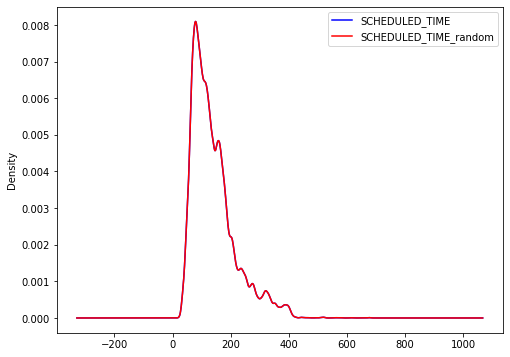

In [53]:
# Plot kde distributions of both distributions
fig = plt.figure(figsize= (8,6))
ax = fig.add_subplot(111)
df_train['SCHEDULED_TIME'].plot(kind='kde', ax=ax, color = 'blue')
df_train['SCHEDULED_TIME_random'].plot(kind='kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

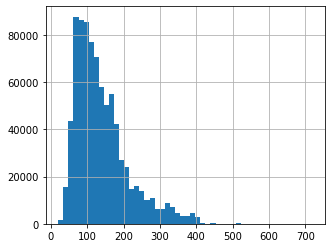

In [38]:
# Plot histogram of SCHEDULED_TIME
df_train['SCHEDULED_TIME'].hist(bins=50)
plt.show()

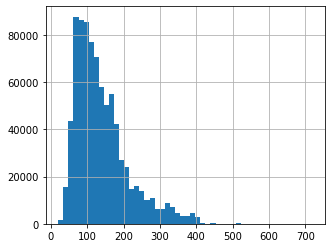

In [39]:
# Plot histogram of SCHEDULED_TIME_end_distribution
df_train['SCHEDULED_TIME_random'].hist(bins=50)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


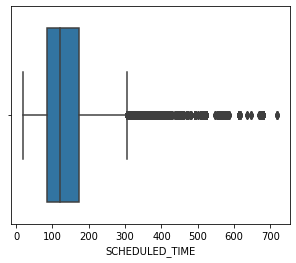

In [40]:
# Boxplot of column
sns.boxplot('SCHEDULED_TIME',data=df_train)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


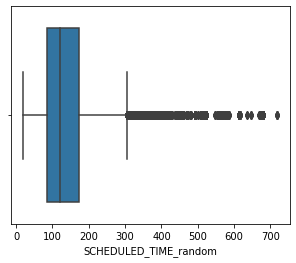

In [41]:
# Boxplot of column
sns.boxplot('SCHEDULED_TIME_random',data=df_train)
plt.show()

##### Categorical Columns

In [42]:
# Print the dataframe
df_train.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,CANCELLED,SCHEDULED_TIME_random
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,205.0,1448,430,0,205.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,280.0,2330,750,0,280.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,286.0,2296,806,0,286.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,285.0,2342,805,0,285.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,235.0,1448,320,0,235.0


In [54]:
# Select categorical columns
cat_cols = df_train.select_dtypes(exclude=['int', 'float']).columns
cat_cols = set(cat_cols) - {target}
catt_col = list(cat_cols)

In [55]:
# Check for missing values
catt_col = list(cat_cols)

df_train[catt_col].isnull().sum()

TAIL_NUMBER            5981
AIRLINE                   0
ORIGIN_AIRPORT            0
DESTINATION_AIRPORT       0
dtype: int64

In [56]:
# check for missing values and sort mean in ascending order
df_train[catt_col].isnull().mean().sort_values(ascending=True)

AIRLINE                0.00000
ORIGIN_AIRPORT         0.00000
DESTINATION_AIRPORT    0.00000
TAIL_NUMBER            0.00713
dtype: float64

In [58]:
# Check for the mode of the distribution
print(df_train['TAIL_NUMBER'].value_counts().index[0])
print(df_train['TAIL_NUMBER'].mode()[0])


N477HA
N477HA


In [65]:
# create imputer function for categorical columns
def impute_nan(df,variable):
    most_frequent_category=df[variable].mode()[0]
    df[variable].fillna(most_frequent_category,inplace=True)

In [68]:
# Apply function on categorical columns

for feature in catt_col:
    impute_nan(df_train[catt_col],feature)

df_train[catt_col].isnull().sum()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


TAIL_NUMBER            5981
AIRLINE                   0
ORIGIN_AIRPORT            0
DESTINATION_AIRPORT       0
dtype: int64

In [67]:
# Check for missing values
df_train[catt_col].isnull().sum()

TAIL_NUMBER            5981
AIRLINE                   0
ORIGIN_AIRPORT            0
DESTINATION_AIRPORT       0
dtype: int64

In [ ]:
# Using the mode to replace missing values
df_cat['TAIL_NUMBER'].fillna(df_cat['TAIL_NUMBER'].mode()[0],inplace=True)
df_cat.head()

df_cat.isnull().sum()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


TAIL_NUMBER        0
CANCELLED          0
TAIL_NUMBER_Var    0
dtype: int64

#### Handling Categorical Data

In [ ]:
# one-hot encoding without many categories
df_cat = train_missing_df[['TAIL_NUMBER', 'CANCELLED']]



In [ ]:
# one-hot encoding with many categories
df_cat = train_missing_df[['TAIL_NUMBER', 'CANCELLED']]
for i in df_cat.columns:
    print(len(df_cat[i].unique()))

4479
2


In [ ]:
# Show the TOP 10 categories in descending order
df_cat.TAIL_NUMBER.value_counts().sort_values(ascending=False).head(10)

N477HA    651
N476HA    637
N485HA    637
N488HA    635
N489HA    622
N491HA    616
N487HA    603
N486HA    597
N483HA    588
N493HA    577
Name: TAIL_NUMBER, dtype: int64